<div class="alert alert-block alert-success">
    <h1>DataLab HvA - serie Machine Learning Python - Tech report 13</h1>
</div>

<div class="alert alert-block alert-warning">
    <h2>Clustering: K-means</h2>
</div>

### 0. Doel van deze les
Dit is het eerste Tech report in de serie clustering technieken. Dit is een vorm van *unsupervised* learning, dat wil zeggen dat we geen *gelabelde* data tot onze beschikking hebben, oftewel: er is geen informatie op voorhand m.b.t. een *afhankelijke variabele*. Clustering is eigenlijk een vorm van *Verkennende data analyse* waarin je wil verkennen of er op basis van de data een indeling in klasses (clusters) gemaakt kan worden. Als deze onderverdeling er is dient de vraag te worden beantwoord of deze betekenisvol is m.b.t. de context van de data dan wel bruikbaar voor vervolgstappen in een datascience project. Deze laatste twee aspecten blijven buiten beschouwing.

Een algoritme dat deze vorm van unsupervised learning kan uitvoeren is *K-means*. Deze methode gaat uit van een klein aantal (*K*) datapunten (als dan niet onderdeel van de dataset zelf) - *centroids* - waaromheen de overige datapunten die bij dezelfde klasse horen geclusterd worden. De gehele dataset zal dus worden verdeeld over deze *K* clusters (partitional clustering).

*K-means* is een relatief eenvoudig algoritme en zal daarom relatief snel werken, waarmee het ook geschikt is voor grote datasets. 
**Je leert** 
- hoe je in Python met behulp van het package `sklearn` een K-means kan toepassen op een gegeven dataset
- een methode om een optimaal aantal clusers te vinden
- hoe je het het resultaat van de gevonden clustering kan weergeven

**Je leert niet:**
- wat de preciese wiskundige definitie en werking van het algoritme is
- hoe je met het package `seaborn` eerste visuele verkenningen van de (variatie in de) data kan uitvoeren, zie hiervoor *Tech report 1: Introductie Machine Learning* uit deze serie.
- hoe je data importeert en inlaadt in de python sessie, zie hiervoor echter wel [deze instructie](https://www.youtube.com/watch?v=1oBVx7pyuXo&list=PLwkTCAI_gJjW10xaAJpdqeQx7EQgFolfG&index=10) 

**Machine Learning framework**
Omdat we geen gelabelde data hebben kunnen we - anders dan bij supervised learning - geen score metric bijhouden die we bijvoorbeeld voor een train en testset gaan vergelijken. Er zijn wel scoremetrics voor clustering in het algemeen, zie verderop.

Een belangrijke bron voor dit Tech report is [dit boek](https://cssbook.net/content/chapter07.html#sec-clustering) (Hoofdstuk 7.3).

### 1. Laden van de benodigde packages
Packages die je zelf nog niet hebt geinstalleerd dien je vooraf in Python te installeren. 

In [1]:
# Voor de dataset en plots
import matplotlib.pyplot as plt
import seaborn as sns

# Voor het bewerken en inspecteren van de data
import pandas as pd
import numpy as np

# Voor het modelleren
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

### 2. Laden en prepareren van de data

We gebruiken als voorbeeld een dataset van de Eurobarometer van het Leibniz Institute for the Social Sciences – GESIS. De data kan online worden geimporteerd, zie onder. Het betreft data van onderzoek met betrekking tot opvang van migranten en vluchtelingen in Europese landen.

#### Laden en weergave data
Hieronder laden we de data en geven enkele kenmerken van de set weer. 

In [2]:
warnings.filterwarnings('ignore')
url = "https://cssbook.net/d/eurobarom_nov_2017.csv"
d2 = pd.read_csv(url)

In [3]:
print("Shape data =", d2.shape)
print(d2.head(3))
print(d2.dtypes)

Shape data = (33193, 17)
                               survey    uniqid                          date  \
0  Eurobarometer 88.3 (November 2017)  16692046  Wednesday, 8th November 2017   
1  Eurobarometer 88.3 (November 2017)  16692045    Tuesday, 7th November 2017   
2  Eurobarometer 88.3 (November 2017)  16692048    Sunday, 12th November 2017   

   country                        marital_status             educational  \
0  Belgium     Divorced/Separated: with children                      24   
1  Belgium              Single: without children          Still studying   
2  Belgium  (Re-)Married: children this marriage  No full-time education   

  gender  age                        occupation     type_community  \
0    Man   48       Professional (lawyer, etc.)         Large town   
1    Man   18                           Student  Small/middle town   
2    Man   65  Owner of a shop, craftsmen, etc.         Large town   

  household_composition support_refugees  support_migrants  date

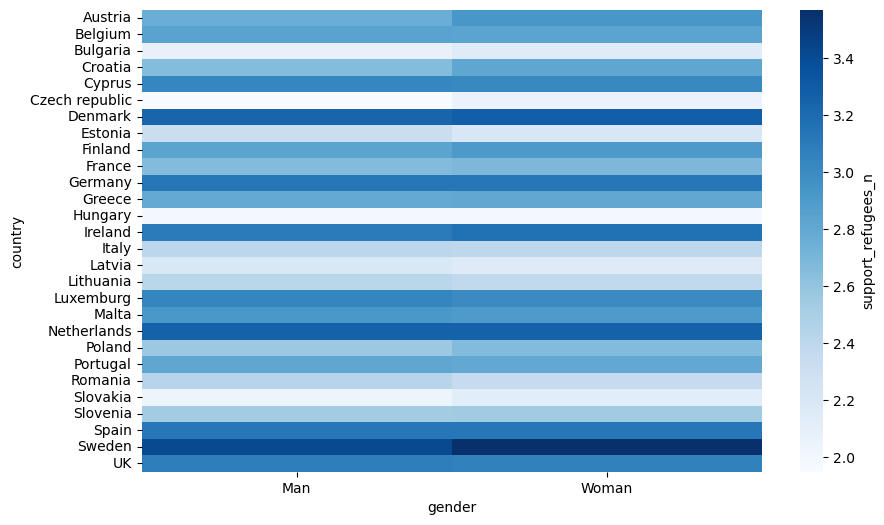

In [4]:
# Een weergave van de verdeling van gegevens m.b.t. ondersteuning vluchtelingenopvang en geslacht van ondervraagde inwoner 
# Samengevat per land
pivot_data = pd.pivot_table(
    d2, values="support_refugees_n", index=["country"], columns="gender"
)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, cmap="Blues", cbar_kws={"label": "support_refugees_n"})
plt.show()

We zetten de data om naar samenvattende (gemiddelde) data van `support_refugees_n`, `support_migrants_n`, `age` en `educational_n`, geordend naar `country`

In [5]:
# Average variables by country and scale
d3 = d2.groupby(["country"])[
    ["support_refugees_n", "support_migrants_n", "age", "educational_n"]
].mean()

print("Shape data =", d3.shape)
print(d3.head(5))
print(d3.dtypes)

Shape data = (34, 4)
           support_refugees_n  support_migrants_n        age  educational_n
country                                                                    
Austria              2.853430            2.544133  48.509843      18.871714
Belgium              2.836901            2.334359  50.405970      19.335221
Bulgaria             2.113025            1.770213  49.632731      19.682773
CRNA GORA                 NaN                 NaN  41.174812      19.533693
Croatia              2.742326            2.024928  45.089580      18.910788
support_refugees_n    float64
support_migrants_n    float64
age                   float64
educational_n         float64
dtype: object


K-means kan niet omgaan met data waarin waarden missen, we inspecteren dit vooraf:

In [6]:
print(" \nTelling van aantal NaN in iedere kolom van het DataFrame : \n\n",
      d3.isnull().sum())

 
Telling van aantal NaN in iedere kolom van het DataFrame : 

 support_refugees_n    6
support_migrants_n    6
age                   0
educational_n         0
dtype: int64


Voor een 6-tal landen ontbreekt data voor `support_refugees_n` en `
support_migrants_` :n

In [7]:
print(d3[d3['support_refugees_n'].isna()])

                               support_refugees_n  support_migrants_n  \
country                                                                 
CRNA GORA                                     NaN                 NaN   
KUZEY KIBRIS TÜRK CUMHURIYETI                 NaN                 NaN   
REPUBLIKA MAKEDONIJA                          NaN                 NaN   
SHQIPERIA                                     NaN                 NaN   
SRPSKI                                        NaN                 NaN   
TURKIYE                                       NaN                 NaN   

                                     age  educational_n  
country                                                  
CRNA GORA                      41.174812      19.533693  
KUZEY KIBRIS TÜRK CUMHURIYETI  39.778000      18.170543  
REPUBLIKA MAKEDONIJA           47.713462      18.320554  
SHQIPERIA                      40.979048      18.654428  
SRPSKI                         44.451039      19.484524  
TURKIYE  

Deze 6 waarnemingen verwijderen we:

In [8]:
d3 = d3[d3['support_refugees_n'].notna()]

Verder van belang (zie ook korte uitleg verderop) dat de *waarden* van de variabelen vergelijkbaar zijn qua grootte. We hebben immers een bepaalde interpretatie van *afstand* tussen waarnemingen nodig die niet beinvloed mag worden door de keuze van de eenheden waarin we meten! Daarom schalen we de data naar een gestandaardiseerd waardebereik per variabele. Run eventueel de codecel hieronder om meer te lezen over deze transformatie.

In [9]:
#help(StandardScaler())

In [10]:
# Definieer een 'scaler'
scaler = StandardScaler()

# Pas de scaler toe op de kolommen van 'd3' en sla op in d3_s
d3_s = scaler.fit_transform(d3)

# het resultaat, d3_s,  is een numpy array waarvan de waarden ro:
d3_s[:5,] #de eerste 5 getransformeerde waarnemingen

array([[ 0.33929097,  0.53054064, -0.93571757, -0.29103295],
       [ 0.29926642,  0.05395776, -0.37553758, -0.06114791],
       [-1.45355728, -1.22771917, -0.60397856,  0.11122725],
       [ 0.07025736, -0.64903451, -1.9461785 , -0.27165326],
       [ 0.75857436, -0.48595901, -0.02809874, -0.46312567]])

### 3. Voorbeschouwing
We vragen ons nu af of er een indeling te maken is van de data in `d3_s` die is gegroepeerd naar verwantschap in de gecombineerde set variabelen `support_refugees_n`, `support_migrants_n`, `age` en `educational_n`. Daarvoor gaan we **K-means** gebruiken, waarbij we het *aantal clusters: K*  vooraf moeten opgeven als modelparameter. 

Het algoritme is gebaseerd op het minimaliseren van een totale (over alle *N* waarnemingen gesommeerde) afstandfunctie:

$$ J=\Sigma_{n = 1}^{N} \Sigma_{k = 1}^{K} r_{nk} \lVert \mathbf{x_n - \mu_k} \rVert ^{2}$$

Hierin zijn $\mathbf{x_n}$ de waarnemingen en $\mathbf{\mu_k}$ de *centroids* van cluster $S_k$ en een clustertoewijzing $r_{nk}$ waarbij $r_{nk} := 1$  als $\mathbf{x_n} \in S_k$ en anders $r_{nk} := 0$. 

De functie $\lVert . \rVert$ definieert de afstand tussen de waarnemingen (gezien als vector, in ons voorbeeld in $\mathbb{R}^4$).

Het algoritme vindt de ligging van de *centroids* $\mathbf{\mu_k}$ en de toewijzing $r_{nk}$ die $J$ minimaliseert.

### 4. Modelleren
#### lees documentatie bij package
Voordat we een model gaan toepassen is het van belang dat je de documentatie van het algoritme dat we uit het package gaan gebruiken lezen. In dit geval is dat dus voor `KMeans()`, die lees je bijvoorbeeld online [hier](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Alternatief is om de `help()` functie te gebruiken, zie hieronder. 

In [11]:
# We gaan de methode DecisionTreeClassifier() uit het sklearn package gebruiken, inspecteer hiervoor de documentatie. Dat kan 
help(KMeans())

Help on KMeans in module sklearn.cluster._kmeans object:

class KMeans(_BaseKMeans)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init='warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      'k-means++' : selects initial cluster centroids using sampling based on
 |      an empirical probability distribution of the points' contribution to the
 |      overall inertia. This technique speeds up convergence. The algorithm
 |      implemented is "greedy k-means++". It differs from the vanilla k-means++
 |      by making several 

Zie bijvoorbeeld de parameters: `n_clusters`, `algorithm`, `init` en `n_init`. Ook lees je dat er een *method*  `fit()` voor deze *object class* gedefinieerd is om het model te *fitten*.

#### model fitten stap 1: bepaal het aantal clusters K
Allereerst moeten we het aantal clusters *K* gaan vaststellen. Wat we daarvoor doen is een aantal waarden voor *K* doorlopen en de *within-cluster sum of squares (WCSS)* (ook wel *inertia* genoemd) plotten van de resulterende clusterindeling. Een goede clustering heeft én een lage waarde voor de *WCSS* én slechts een beperkt aantal clusters (*K*). Hoe meer clusters, hoe lager de waarde *WCSS* zal worden (de clusters worden kleiner), beide voorwaarden werken elkaar dus tegen.

Om tóch een optimaal aantal te vinden is het gebruikelijk de 'knie' (of 'elleboog') in onderstaande plot te identificeren. Dat is waar de afname van de *WCSS* minder hard begint te dalen dan de trend daarvoor. Dit is en blijft wat subjectief!. In onderstaande plot is het optimale aantal *K = 3*  te verdedigen

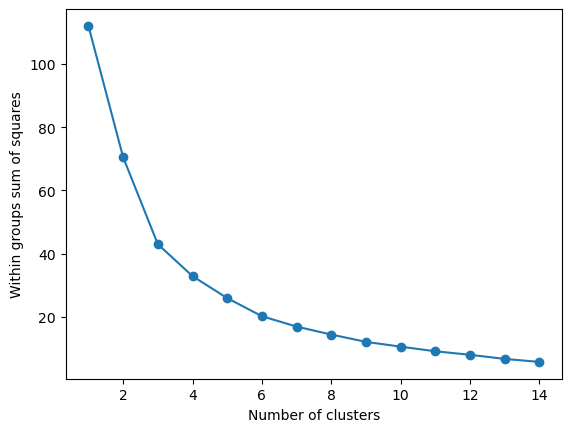

In [12]:
# Store sum of squares for 1..15 clusters
wss = []
for i in range(1, 15):
    km_out = KMeans(n_clusters=i, n_init=20)
    km_out.fit(d3_s)
    wss.append(km_out.inertia_)

plt.plot(range(1, 15), wss, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Within groups sum of squares")
plt.show()

#### model fitten stap 2: fit model

In [13]:
# Compute k-means with k = 3
km_res = KMeans(n_clusters=3, n_init=25).fit(d3_s)
print(km_res)

KMeans(n_clusters=3, n_init=25)


### 5. Model weergeven
Voor het weergeven van (kenmerken van) een de clusterindeling volgen hier enkele voorbeelden:

#### De omvang van elk cluster

In [14]:
print("K-means cluster sizes:", np.bincount(km_res.labels_[km_res.labels_ >= 0]))

K-means cluster sizes: [12 13  3]


#### De ligging van de centroids

In [15]:
print(f"Cluster means: {km_res.cluster_centers_}")

Cluster means: [[ 0.66509211  0.64333892 -0.03329616 -0.40111921]
 [-0.88805399 -0.82663477 -0.37655062 -0.2043732 ]
 [ 1.18786548  1.00872835  1.76490399  2.49009407]]


#### De toewijzing

In [16]:
print("Clustering vector:")
toew = np.column_stack((d3.index, km_res.labels_))
print(toew[toew[:,1].argsort()])


Clustering vector:
[['Austria' 0]
 ['Spain' 0]
 ['Portugal' 0]
 ['Netherlands' 0]
 ['Malta' 0]
 ['Luxemburg' 0]
 ['Germany' 0]
 ['France' 0]
 ['Ireland' 0]
 ['Cyprus' 0]
 ['Belgium' 0]
 ['UK' 0]
 ['Hungary' 1]
 ['Italy' 1]
 ['Latvia' 1]
 ['Lithuania' 1]
 ['Czech republic' 1]
 ['Croatia' 1]
 ['Poland' 1]
 ['Bulgaria' 1]
 ['Romania' 1]
 ['Slovakia' 1]
 ['Slovenia' 1]
 ['Greece' 1]
 ['Estonia' 1]
 ['Sweden' 2]
 ['Finland' 2]
 ['Denmark' 2]]


#### Een plot van de gevonden clusters
Let op: we geven hier op de x en y-as weer: de *herschaalde waarden* voor `support_refugees_n` resp `support_migrants_n`.
Varieer zelf bijvoorbeeld eens over de andere variabelen!

In [17]:
d3.columns

Index(['support_refugees_n', 'support_migrants_n', 'age', 'educational_n'], dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


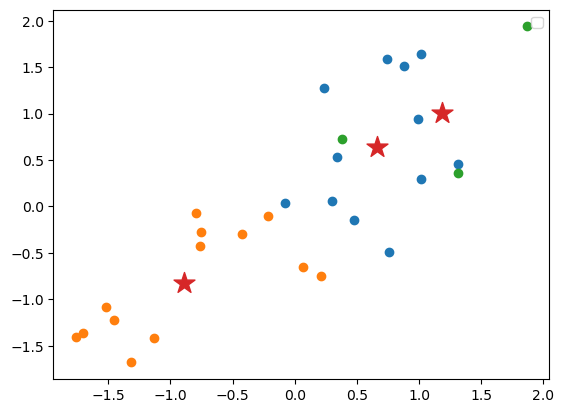

In [18]:
#Keuze van variabelen in de plot:
xas = 0 #'support_refugees_n' = 0, 'support_migrants_n' = 1, 'age' = 2, 'educational_n' = 3
yas = 1 #'support_refugees_n' = 0, 'support_migrants_n' = 1, 'age' = 2, 'educational_n' = 3

for cluster in range(km_res.n_clusters):
    plt.scatter(
        d3_s[km_res.labels_ == cluster, xas], d3_s[km_res.labels_ == cluster, yas]
    )
plt.scatter(
    km_res.cluster_centers_[:, xas],
    km_res.cluster_centers_[:, yas],
    s=250,
    marker="*",
)
plt.legend(scatterpoints=1)
plt.show()